# 1. Proposal:

## What is the problem you are attempting to solve?
<br> 
I want to see if it makes sense to buy or rent in NY/MA/CT next year. The project goals are to bring visibility into the rental and housing market in NY MA and CT and to shed light on the factors that would impact the decision to buy given projected performance of that investment 5 or 10 years into the future using economic data from the Federal Reserve as well as Zillow data. 
<br>

## How is your solution valuable?
<br>
This problem would impact those that are in a position to buy but are not yet sure if the market has bottomed out and if it makes sense to rent for a bit longer. Given the significance in my own life, these three states are the locations I will be looking at specifically. This product would thus be valuable to anyone that is in a similar position of looking at the east coast and attempting to make a big decision as to where to live and where would bring the most potential (from a location and investment perspective). The inputs that I can take from the user would be things like priorities of surrounding areas like proximity to schools or highways or public transportation.
<br>

## What is your data source and how will you access it?
<br>
Zillow data combined with interest rate/unemployment/inflation data. I already have the datasets I need.  They will be sourced from the below links:
<br>
https://www.zillow.com/research/data/ <br>
https://www.kaggle.com/zillow/zecon <br>
https://www.kaggle.com/federalreserve/interest-rates <br>
<br>
The variables I will be looking at the interest rates data, location and listing information for Massachusetts, New York and Connecticut specifically. I may also be scraping data from google maps for proximity to major cities to get commute times. 
<br>

## What techniques from the course do you anticipate using?

<br>
After EDA, cleaning and feature engineering, I will be using the economics specialization for this project, so I will be relying primarily on linear regression (Probit and Tobit) and robust regression (Huber, Thiel-Sen, and RANSAC) to assume performance gains or losses in 5 or 10 years in the future in buying vs renting scenarios as these long term projections would help with making a decision. I will try all these models and see which performs best. I can use K means clustering to create profiles around particular county profiles that would be most advantageous based on proximity to Boston and NYC, as well as schools, public transport and highways. I can also highlight certain counties or towns as suggestions based on this clustering.
<br>

## What do you anticipate to be the biggest challenge you’ll face?
<br>How to compile it all together and leverage the various data sets in a way that is optimal. Bringing in adequate complexity. Scraping the data I need and getting it to work with my dataframes.
<br>

https://www.zillow.com/research/data/ <br>

https://www.kaggle.com/zillow/zecon <br>

https://www.kaggle.com/federalreserve/interest-rates
<br>

Notes:

Sq footage, proximity to city, lot size etc. Input/free variable - how long would we be in that location. 10 years? 5? If able to do regression for an area, see how much housing prices are increasing year over year that could factor in. Mortgage parameters. Etc. 

Clustering techniques, similar neighborhoods in CT/MA/NY
inputs for similarity?
Schools?
Public transit?
Price sq foot
Increase in value 
Proximity to highways 
Colleges
Company headquarters 
Google maps API to pull in ancillary data prox to trains, highways etc. Transit time to grand central or back bay. 

See if we can get data on town/neighborhood level
Rate of increase. 

# 2. Ok Lets begin with loading the data, wrangling, cleaning and EDA:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Here I am importing interest rate data from the 50s to today. I am also importing sale prices of homes as well as rental prices of homes, both sets are from Zillow. 

In [2]:
df_interestrates = pd.read_csv('/Users/ir3n3br4t515/Desktop/index.csv')
df_zillowsale = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_State.csv')
df_zillowrent = pd.read_csv('/Users/ir3n3br4t515/Desktop/State_MedianRentalPrice_AllHomes.csv')
df_daysonzillow = pd.read_csv('/Users/ir3n3br4t515/Desktop/DaysOnZillow_State.csv')
df_sale_city = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_City.csv')
df_pricepsqft = pd.read_csv('/Users/ir3n3br4t515/Desktop/State_MedianListingPricePerSqft_AllHomes.csv')




In [3]:
def transform_date(year, month):
    year = str(year).split(".")[0]
    month = str(month).split(".")[0]
    if len(month)==1:
        month = "0" + month
    return year + "-" + month

In [4]:
df_interestrates["date"] = df_interestrates.apply(lambda x: transform_date(x.Year, x.Month), axis=1)

In [5]:
#I will only be looking at the year, month, unemployment, inflation and effective federal funds rates for each year so i will make a new df.
df_econ = df_interestrates[['date', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
df_econ.head()

,date,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate
0,1954-07,5.8,NaN,0.80
1,1954-08,6.0,NaN,1.22
2,1954-09,6.1,NaN,1.06
3,1954-10,5.7,NaN,0.85
4,1954-11,5.3,NaN,0.83


In [6]:
df_econ = df_econ.set_index("date")

In [7]:
df_econ_transposed = df_econ.T
df_econ_transposed.head()

date,1954-07,1954-08,1954-09,1954-10,1954-11,1954-12,1955-01,1955-02,1955-03,1955-04,...,2016-08,2016-09,2016-10,2016-11,2016-12,2016-12,2017-01,2017-02,2017-03,2017-03
Unemployment Rate,5.8,6.00,6.10,5.70,5.30,5.00,4.90,4.70,4.60,4.70,...,4.9,4.9,4.8,4.60,4.70,NaN,4.80,4.70,NaN,NaN
Inflation Rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.3,2.2,2.1,2.10,2.20,NaN,2.30,2.20,NaN,NaN
Effective Federal Funds Rate,0.8,1.22,1.06,0.85,0.83,1.28,1.39,1.29,1.35,1.43,...,0.4,0.4,0.4,0.41,0.54,NaN,0.65,0.66,NaN,NaN


### Below I am creating new dfs for our rent and sale data so that we are looking only at MA, NY and CT as these are the three states we are interested in based on the proposal. 

### DF_Rent is first 

In [8]:
df_rent = df_zillowrent.iloc[[2, 13, 28]]

df_rent.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
2,New York,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3150,3100,3195.0,3200.0,3490,3295,3260,3200,3375.0,3234.0
13,Massachusetts,14,NaN,NaN,1552.5,1675.0,1552.5,1775.0,1550.0,1600.0,...,2500,2550,2600.0,2699.0,2700,2700,2700,2695,2599.0,2500.0
28,Connecticut,29,NaN,1700.0,1800.0,1900.0,1850.0,2000.0,1875.0,1800.0,...,1700,1725,1750.0,1800.0,1800,1850,1850,1850,1800.0,1800.0


In [9]:
df_rent = df_rent.T
df_rent.columns = ["NY_R", "MA_R", "CT_R"]

In [10]:
df_rent = df_rent.drop("RegionName", axis=0)
df_rent = df_rent.drop("SizeRank", axis=0)

In [11]:
df_rent.head()

,NY_R,MA_R,CT_R
2010-01,NaN,NaN,NaN
2010-02,NaN,NaN,1700
2010-03,NaN,1552.5,1800
2010-04,NaN,1675,1900
2010-05,NaN,1552.5,1850


### DF_Sale second 

In [12]:
df_sale = df_zillowsale.iloc[[1, 12, 27]]
df_sale.head(100)

,RegionID,RegionName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
1,43,New York,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,291200,297800,297400,294700,292600.0,296500.0,306300.0,311100.0,314400.0,NaN
12,26,Massachusetts,13,314500.0,309500.0,297400.0,291300.0,287900.0,288200.0,285400.0,...,368000,368500,378400,388000,390200.0,384100.0,383300.0,385800.0,385600.0,NaN
27,11,Connecticut,28,264000.0,263100.0,254900.0,242200.0,237300.0,237600.0,238700.0,...,236500,236500,234800,238800,241500.0,247300.0,242800.0,241000.0,239100.0,NaN


In [13]:
df_sale = df_sale.T
df_sale.columns = ["NY_S", "MA_S", "CT_S"]

In [14]:
df_sale = df_sale.drop("RegionName", axis=0)
df_sale = df_sale.drop("RegionID", axis=0)
df_sale = df_sale.drop("SizeRank", axis=0)

In [15]:
df_sale.head(100)

,NY_S,MA_S,CT_S
2008-03,NaN,314500,264000
2008-04,NaN,309500,263100
2008-05,NaN,297400,254900
2008-06,NaN,291300,242200
2008-07,NaN,287900,237300
...,...,...,...
2016-02,233400,328600,222400
2016-03,236400,326600,222800
2016-04,240400,328500,223800
2016-05,239400,327600,222400


### Days on Zillow data is third 

In [16]:
df_daysonzillow.head(100)

,SizeRank,RegionID,RegionName,RegionType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,1.0,9,California,State,109.0,115.0,107.0,103.0,89.0,91.0,...,73.0,83.0,82.0,62.0,58.0,56.0,57.0,60.0,62.0,64
1,2.0,54,Texas,State,121.0,124.0,122.0,112.0,98.0,100.0,...,82.0,88.0,88.0,73.0,66.0,63.0,63.0,63.0,66.0,73
2,3.0,43,New York,State,189.0,193.0,192.0,185.0,180.0,135.0,...,128.0,140.0,145.0,150.0,145.0,119.0,112.0,112.0,113.0,120
3,4.0,14,Florida,State,163.0,157.0,155.0,158.0,152.0,131.0,...,88.0,95.0,100.0,95.0,87.0,87.0,86.0,85.0,84.0,85
4,5.0,21,Illinois,State,174.0,177.0,178.0,181.0,161.0,129.0,...,105.0,116.0,126.0,121.0,83.0,75.0,76.0,80.0,83.0,88
5,6.0,47,Pennsylvania,State,137.0,150.0,151.0,152.0,122.0,112.0,...,89.0,98.0,107.0,104.0,83.0,73.0,72.0,73.0,75.0,77
6,7.0,44,Ohio,State,143.0,153.0,153.0,152.0,124.0,110.0,...,78.0,88.0,96.0,81.0,66.0,60.0,59.0,61.0,62.0,63
7,8.0,30,Michigan,State,135.0,140.0,140.0,143.0,125.0,115.0,...,81.0,91.0,95.0,92.0,72.0,62.0,61.0,63.0,66.0,70
8,9.0,16,Georgia,State,158.0,164.0,161.0,160.0,152.0,126.0,...,81.0,89.0,89.0,67.0,68.0,64.0,64.0,67.0,69.0,73
9,10.0,36,North Carolina,State,172.0,170.0,167.0,175.0,141.0,126.0,...,82.0,91.0,92.0,72.0,63.0,61.0,63.0,63.0,67.0,70


In [17]:
df_dayszillow = df_daysonzillow.iloc[[2, 13, 28]]
df_dayszillow.head()


,SizeRank,RegionID,RegionName,RegionType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
2,3.0,43,New York,State,189.0,193.0,192.0,185.0,180.0,135.0,...,128.0,140.0,145.0,150.0,145.0,119.0,112.0,112.0,113.0,120
13,14.0,26,Massachusetts,State,149.0,157.0,153.0,153.0,118.0,110.0,...,79.0,93.0,105.0,84.0,70.0,67.0,66.0,69.0,72.0,77
28,29.0,11,Connecticut,State,152.0,160.0,166.0,159.0,146.0,115.0,...,104.0,119.0,123.0,125.0,97.0,87.0,81.0,82.0,87.0,94


In [18]:
df_dayszillow = df_dayszillow.T
df_dayszillow.columns = ["NY_days", "MA_days", "CT_days"]

In [19]:
df_dayszillow = df_dayszillow.drop("RegionName", axis=0)
df_dayszillow = df_dayszillow.drop("RegionID", axis=0)
df_dayszillow = df_dayszillow.drop("SizeRank", axis=0)

In [20]:
df_dayszillow.head()

,NY_days,MA_days,CT_days
RegionType,State,State,State
2010-01,189,149,152
2010-02,193,157,160
2010-03,192,153,166
2010-04,185,153,159


### Price Per Sq Ft is fourth. 

In [21]:
df_pricepsqft.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,California,1,210.117014,213.913415,215.515176,218.470343,219.435737,219.593665,216.994638,215.915617,...,308.848080,314.343087,320.359281,325.009560,323.809524,324.306252,323.155894,321.212121,322.713308,323.105102
1,Texas,2,85.757867,86.131934,86.633663,86.944938,86.935406,86.698795,85.991245,85.588467,...,126.404743,127.062333,128.057091,129.592471,129.731514,130.081301,129.933397,129.761481,129.986245,129.841549
2,New York,3,180.250784,175.585284,177.476852,176.430518,186.623514,187.713956,188.235294,184.601113,...,197.722052,202.093589,206.700644,209.821429,204.865235,200.806452,194.529906,191.250000,193.421053,194.348928
3,Florida,4,119.438669,118.257963,116.842517,115.427233,114.443349,112.030075,110.347461,109.138906,...,166.242617,166.666667,165.797788,167.178477,166.223618,166.216755,166.349810,166.527662,166.286496,165.833333
4,Illinois,5,137.610619,137.273902,137.751856,137.502866,136.274510,135.099462,131.513158,130.655894,...,147.523709,150.706155,153.802198,156.339286,155.097518,154.700222,153.086420,150.796312,149.966674,149.046105


In [22]:
df_ppsqft = df_pricepsqft.iloc[[2, 13, 28]]
df_ppsqft.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
2,New York,3,180.250784,175.585284,177.476852,176.430518,186.623514,187.713956,188.235294,184.601113,...,197.722052,202.093589,206.700644,209.821429,204.865235,200.806452,194.529906,191.250000,193.421053,194.348928
13,Massachusetts,14,202.110390,202.631579,203.061224,203.533139,203.660089,202.104146,200.089127,197.967086,...,251.877682,255.712528,261.964736,268.120605,270.356234,270.270270,267.461089,264.730290,268.493582,268.352060
28,Connecticut,29,178.490260,178.508753,179.954083,178.654645,178.707224,178.502747,176.476945,175.508318,...,170.225225,173.257840,175.891759,177.693966,178.472222,177.619893,177.125506,174.821708,175.000000,174.031366


In [23]:
df_ppsqft = df_ppsqft.T


In [24]:
df_ppsqft.columns = ["NY_SqF", "MA_SqF", "CT_SqF"]

In [25]:
df_ppsqft = df_ppsqft.drop("RegionName", axis=0)
df_ppsqft = df_ppsqft.drop("SizeRank", axis=0)

In [26]:
df_ppsqft.head()

,NY_SqF,MA_SqF,CT_SqF
2010-01,180.251,202.11,178.49
2010-02,175.585,202.632,178.509
2010-03,177.477,203.061,179.954
2010-04,176.431,203.533,178.655
2010-05,186.624,203.66,178.707


### And finally the sale price in each City! 

In [27]:
df_sale_city.head()

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,...,556900.0,564200.0,562500.0,576400.0,560600.0,561700.0,566300.0,567000.0,563800.0,554900.0
1,12447,Los Angeles,California,2,506200.0,487600.0,463200.0,453900.0,438700.0,423500.0,...,682200.0,685400.0,701200.0,699900.0,701100.0,703700.0,708900.0,713700.0,710300.0,709900.0
2,39051,Houston,Texas,3,138400.0,134700.0,131200.0,129600.0,132000.0,134000.0,...,210500.0,206500.0,207700.0,206300.0,210700.0,211600.0,210300.0,209900.0,207000.0,212100.0
3,17426,Chicago,Illinois,4,329700.0,320400.0,295600.0,276600.0,269400.0,265900.0,...,255600.0,266500.0,299900.0,298300.0,287600.0,277700.0,275400.0,272800.0,270600.0,266200.0
4,6915,San Antonio,Texas,5,130300.0,131300.0,131300.0,131700.0,131700.0,132600.0,...,190500.0,189500.0,191100.0,193600.0,196500.0,197600.0,199400.0,201100.0,201600.0,204400.0


In [28]:
df_sale_city = df_sale_city.iloc[[0, 25]]
df_sale_city.head()

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,...,556900.0,564200.0,562500.0,576400.0,560600.0,561700.0,566300.0,567000.0,563800.0,554900.0
25,44269,Boston,Massachusetts,26,NaN,NaN,NaN,NaN,NaN,NaN,...,631800.0,636900.0,636200.0,642500.0,635300.0,638600.0,654500.0,650900.0,651800.0,640600.0


In [29]:
df_city = df_sale_city.T
df_city.head()

,0,25
RegionID,6181,44269
RegionName,New York,Boston
StateName,New York,Massachusetts
SizeRank,1,26
2008-03,NaN,NaN


In [30]:
df_city.columns = ["NYC_S", "Boston_S"]

In [31]:
df_city = df_city.drop("RegionName", axis=0)
df_city = df_city.drop("SizeRank", axis=0)

In [32]:
df_city.head()

,NYC_S,Boston_S
RegionID,6181,44269
StateName,New York,Massachusetts
2008-03,NaN,NaN
2008-04,NaN,NaN
2008-05,NaN,NaN


### Done! Now we can combine them. 

In [33]:
df_combined = df_econ.merge(df_sale, left_index=True, right_index=True)

In [34]:
df_combined = df_combined.merge(df_rent, left_index=True, right_index=True)

In [35]:
df_combined.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,CT_S,NY_R,MA_R,CT_R
2010-01,9.8,1.6,0.11,NaN,279500,234400,NaN,NaN,NaN
2010-02,9.8,1.3,0.13,NaN,289800,238800,NaN,NaN,1700
2010-03,9.9,1.1,0.16,NaN,289100,244600,NaN,1552.5,1800
2010-04,9.9,0.9,0.20,NaN,288300,242700,NaN,1675,1900
2010-05,9.6,0.9,0.20,NaN,281500,235600,NaN,1552.5,1850


In [36]:
df_combined = df_combined.merge(df_ppsqft, left_index=True, right_index=True)

In [37]:
df_combined = df_combined.merge(df_dayszillow, left_index=True, right_index=True)

In [38]:
df_combined = df_combined.merge(df_city, left_index=True, right_index=True)

In [39]:
df_combined.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,CT_S,NY_R,MA_R,CT_R,NY_SqF,MA_SqF,CT_SqF,NY_days,MA_days,CT_days,NYC_S,Boston_S
2010-01,9.8,1.6,0.11,NaN,279500,234400,NaN,NaN,NaN,180.251,202.11,178.49,189,149,152,NaN,NaN
2010-02,9.8,1.3,0.13,NaN,289800,238800,NaN,NaN,1700,175.585,202.632,178.509,193,157,160,NaN,NaN
2010-03,9.9,1.1,0.16,NaN,289100,244600,NaN,1552.5,1800,177.477,203.061,179.954,192,153,166,NaN,NaN
2010-04,9.9,0.9,0.20,NaN,288300,242700,NaN,1675,1900,176.431,203.533,178.655,185,153,159,NaN,NaN
2010-05,9.6,0.9,0.20,NaN,281500,235600,NaN,1552.5,1850,186.624,203.66,178.707,180,118,146,NaN,NaN


### Let's see how much of our data we are missing!

In [40]:
df_combined.isnull().sum()*100/df_combined.count()


Unemployment Rate                4.651163
Inflation Rate                   4.651163
Effective Federal Funds Rate     4.651163
NY_S                            13.924051
MA_S                             0.000000
CT_S                             0.000000
NY_R                            18.421053
MA_R                             2.272727
CT_R                             1.123596
NY_SqF                           0.000000
MA_SqF                           0.000000
CT_SqF                           0.000000
NY_days                          0.000000
MA_days                          0.000000
CT_days                          0.000000
NYC_S                           13.924051
Boston_S                        47.540984
dtype: float64

In [41]:
df_final = df_combined.fillna(df_combined.mean())

In [42]:
df_final.isnull().sum()*100/df_final.count()


Unemployment Rate               0.0
Inflation Rate                  0.0
Effective Federal Funds Rate    0.0
NY_S                            0.0
MA_S                            0.0
CT_S                            0.0
NY_R                            0.0
MA_R                            0.0
CT_R                            0.0
NY_SqF                          0.0
MA_SqF                          0.0
CT_SqF                          0.0
NY_days                         0.0
MA_days                         0.0
CT_days                         0.0
NYC_S                           0.0
Boston_S                        0.0
dtype: float64

In [43]:
df_final.shape

(90, 17)

### Ok we have filled in our nulls with averages so as not to disrupt our data or lose our rows of missing values. 

### Next let's take a look at our outliers and remove those that are more than 2 standard deviations. 

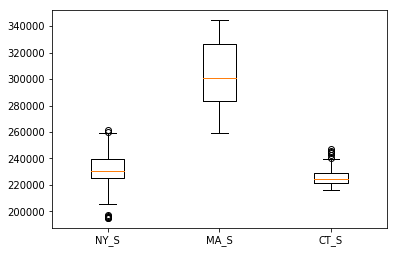

In [56]:
plt.boxplot([df_final.NY_S, df_final.MA_S, df_final.CT_S])
plt.xticks([1,2,3], ['NY_S','MA_S', 'CT_S'])
plt.show()

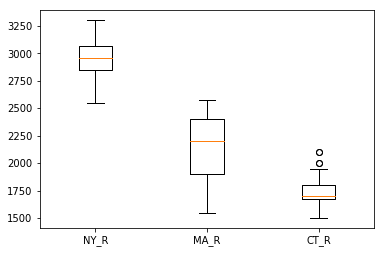

In [57]:
plt.boxplot([df_final.NY_R, df_final.MA_R, df_final.CT_R])
plt.xticks([1,2,3], ['NY_R','MA_R', 'CT_R'])
plt.show()

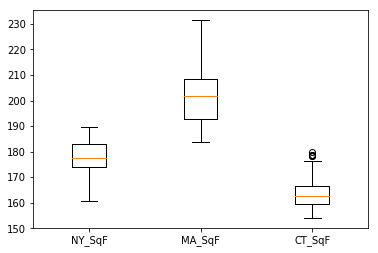

In [58]:
plt.boxplot([df_final.NY_SqF, df_final.MA_SqF, df_final.CT_SqF])
plt.xticks([1,2,3], ['NY_SqF','MA_SqF', 'CT_SqF'])
plt.show()

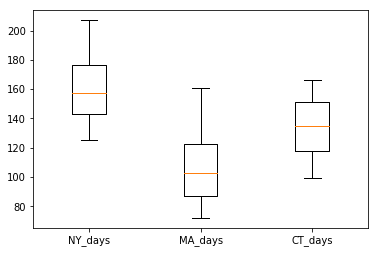

In [59]:
plt.boxplot([df_final.NY_days, df_final.MA_days, df_final.CT_days])
plt.xticks([1,2,3], ['NY_days','MA_days', 'CT_days'])
plt.show()

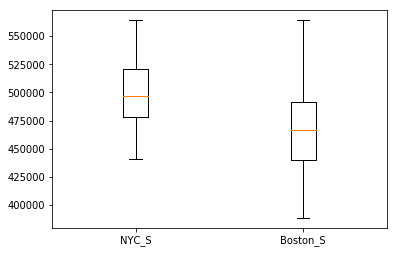

In [60]:
plt.boxplot([df_final.NYC_S, df_final.Boston_S])
plt.xticks([1,2], ['NYC_S','Boston_S'])
plt.show()

In [44]:

from scipy import stats

df_product = df_final[(np.abs(stats.zscore(df_final)) < 3).all(axis=1)]


### And some EDA

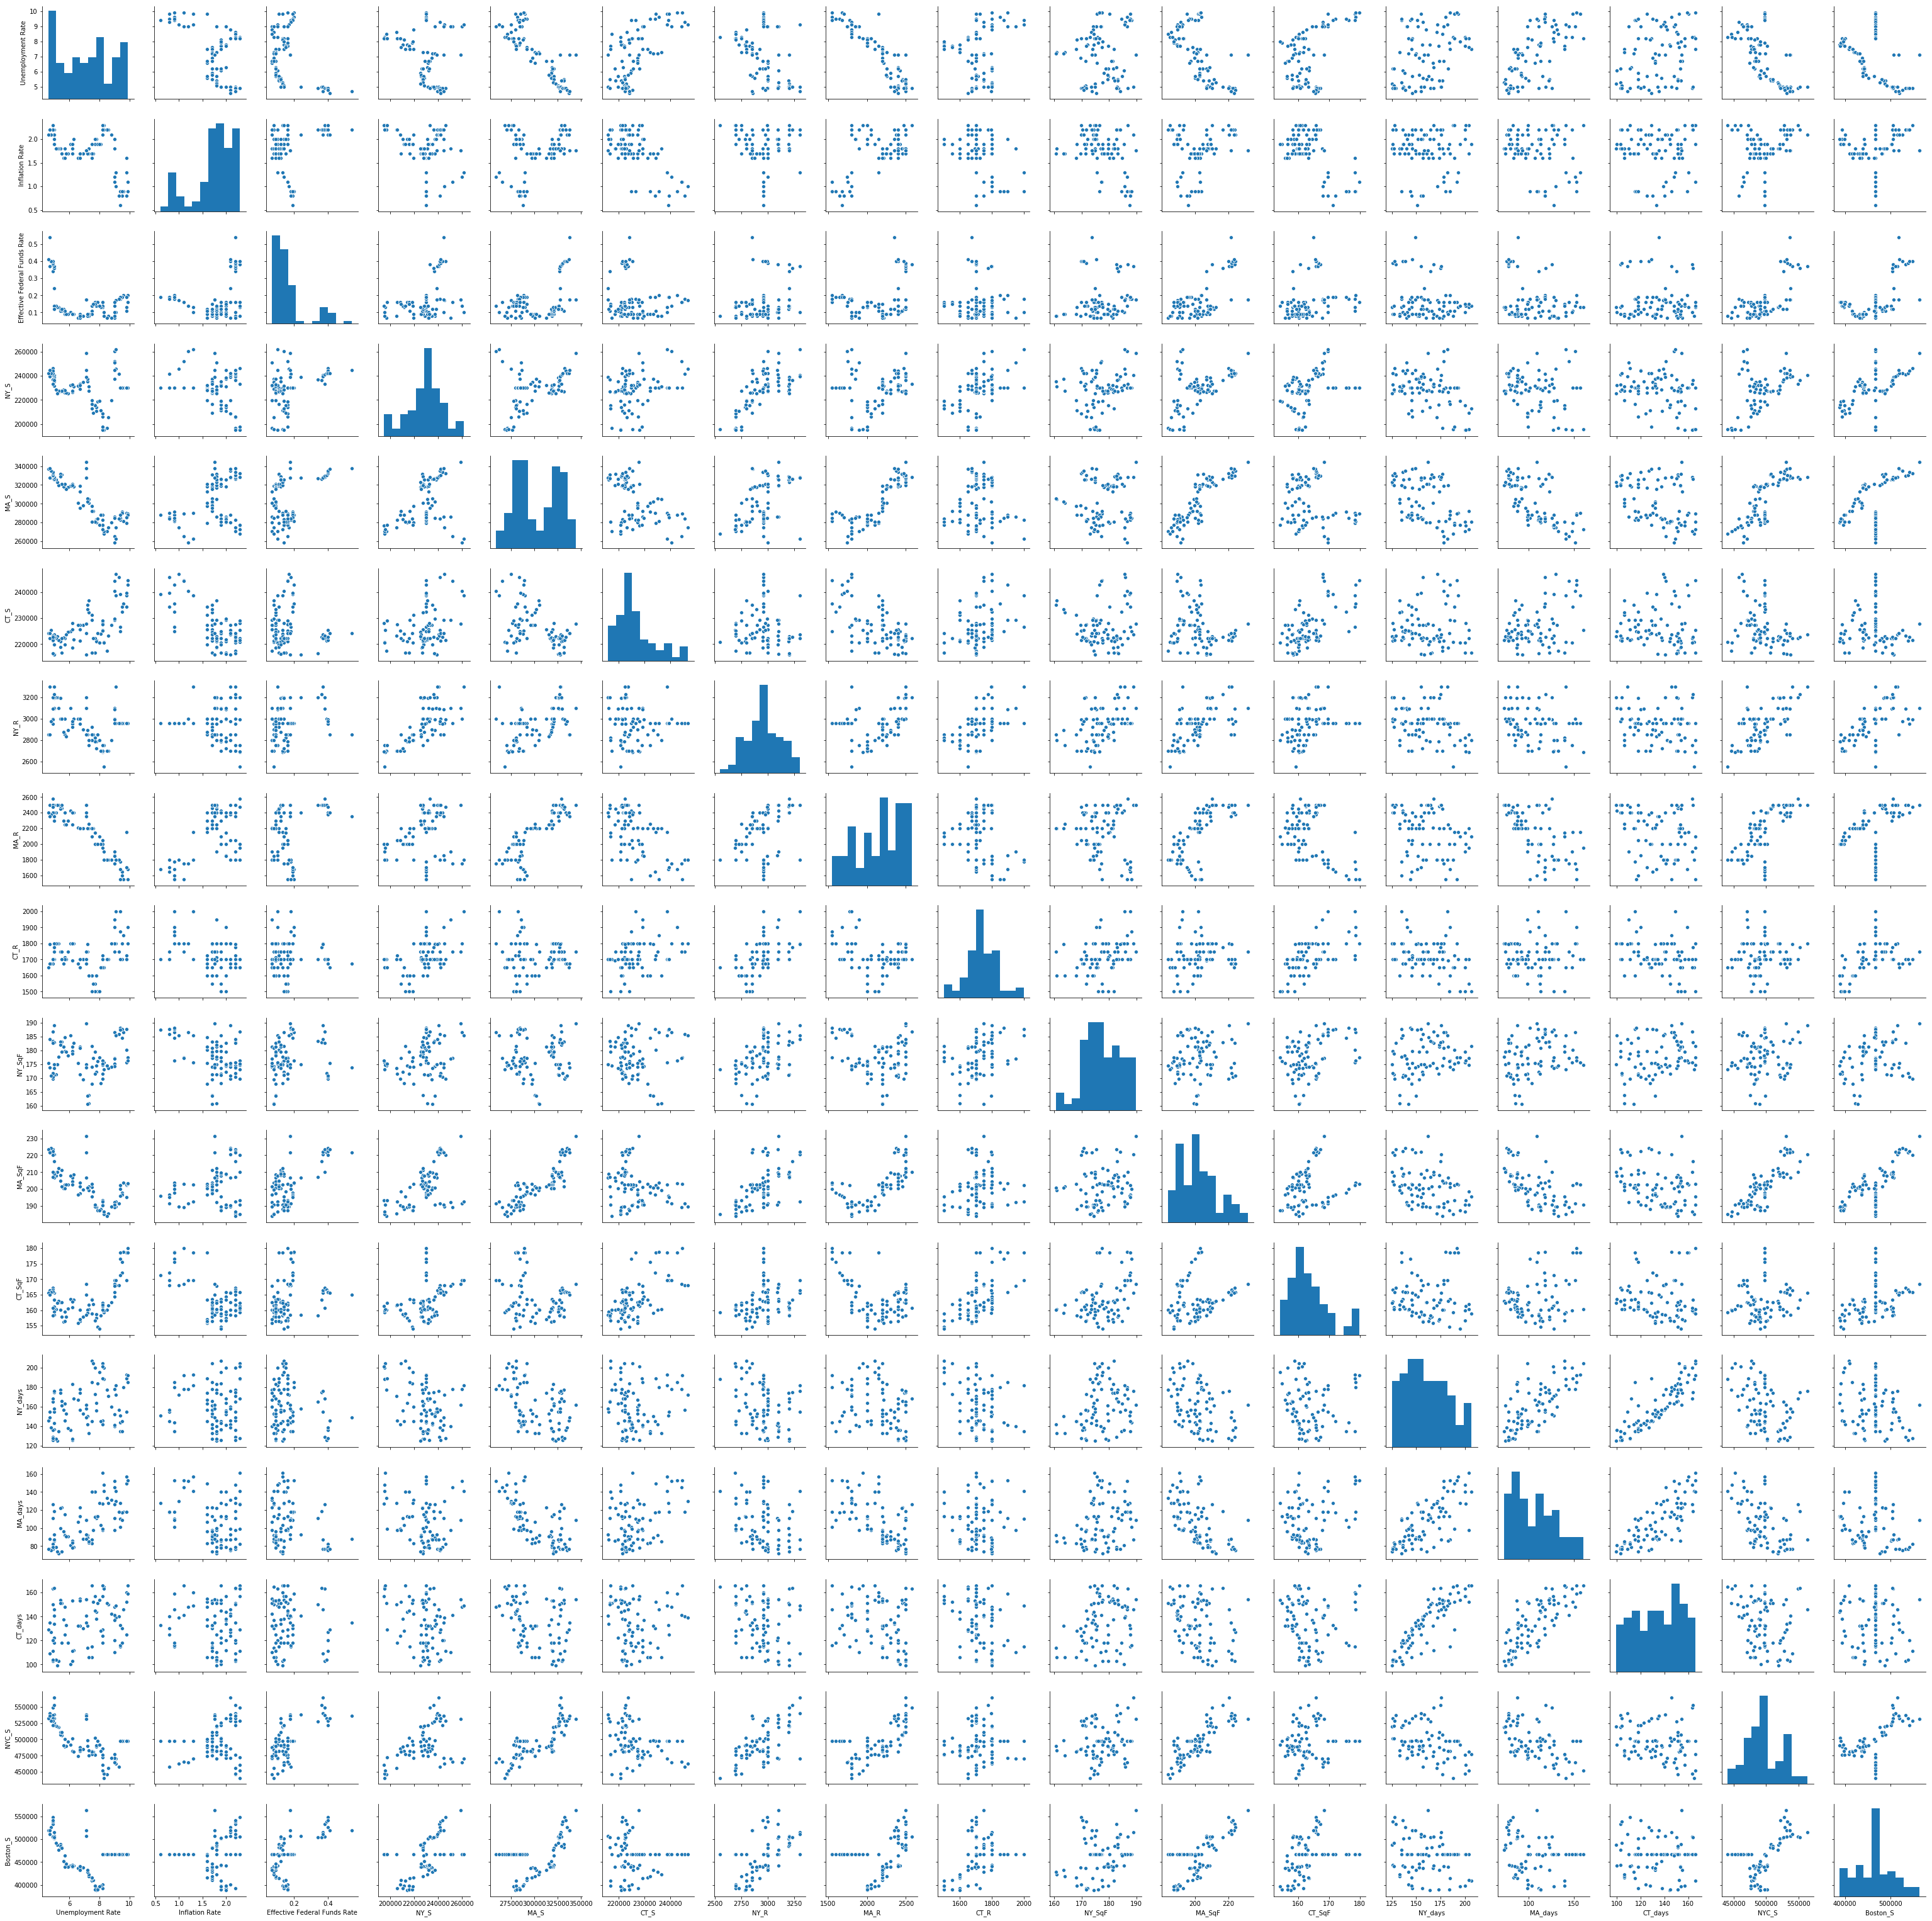

In [45]:

sns.pairplot(df_product, size=2.5);


In [46]:
df_product.describe()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,CT_S,NY_R,MA_R,CT_R,NY_SqF,MA_SqF,CT_SqF,NY_days,MA_days,CT_days,NYC_S,Boston_S
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,7.133640,1.757626,0.165206,229121.047984,303352.325581,226483.720930,2951.911873,2150.235862,1718.590933,177.697088,202.315750,163.596329,160.523256,106.598837,134.488372,497064.645275,464828.192909
std,1.671367,0.425106,0.102015,14882.954323,23131.555868,7414.022651,161.253613,287.944961,98.358614,6.664651,11.338969,6.132771,21.875975,23.629097,19.204469,26594.964936,41458.155685
min,4.600000,0.600000,0.070000,195000.000000,258900.000000,216000.000000,2550.000000,1550.000000,1500.000000,160.656535,183.888889,154.044243,125.000000,72.000000,99.000000,440700.000000,388400.000000
25%,5.500000,1.700000,0.090000,225125.000000,283600.000000,221625.000000,2850.000000,1912.500000,1675.000000,173.803158,192.572449,159.506986,143.250000,87.000000,118.000000,480600.000000,439350.000000
50%,7.200000,1.800000,0.140000,230164.556962,300700.000000,224300.000000,2957.815789,2200.000000,1700.000000,177.150933,201.649258,162.262989,157.500000,102.000000,135.000000,497241.772152,466878.688525
75%,8.450000,2.100000,0.178605,238325.000000,325800.000000,229200.000000,3000.000000,2400.000000,1795.000000,182.883390,208.136292,166.302952,177.000000,123.000000,151.000000,519075.000000,489100.000000
max,9.900000,2.300000,0.540000,261700.000000,344400.000000,246800.000000,3300.000000,2575.000000,2000.000000,189.710706,231.395797,179.954083,207.000000,161.000000,166.000000,564000.000000,564100.000000


In [47]:
df_product.shape 

(86, 17)

Notes from Andrew call last: For loop - for every row in this df, im gonna generate a request thats shaped like this: (use requests python library) every request i send hopefuly gets a response. I can save that to raw json to different files. Can save it to a new df if i want. Save it as a python list. Where each element is JSON data. Potentially if we have a lot of rows that we're generating requests for we might have an issue with rate limits and it might take a while to run. Could put in delays between requests. 

Maybe going from listing to town level. Or county.

### Let's take a look at the distribution of each of our variables which we've already selected prior because we knew we wanted to focus on MA, CT and NY for all these data points.

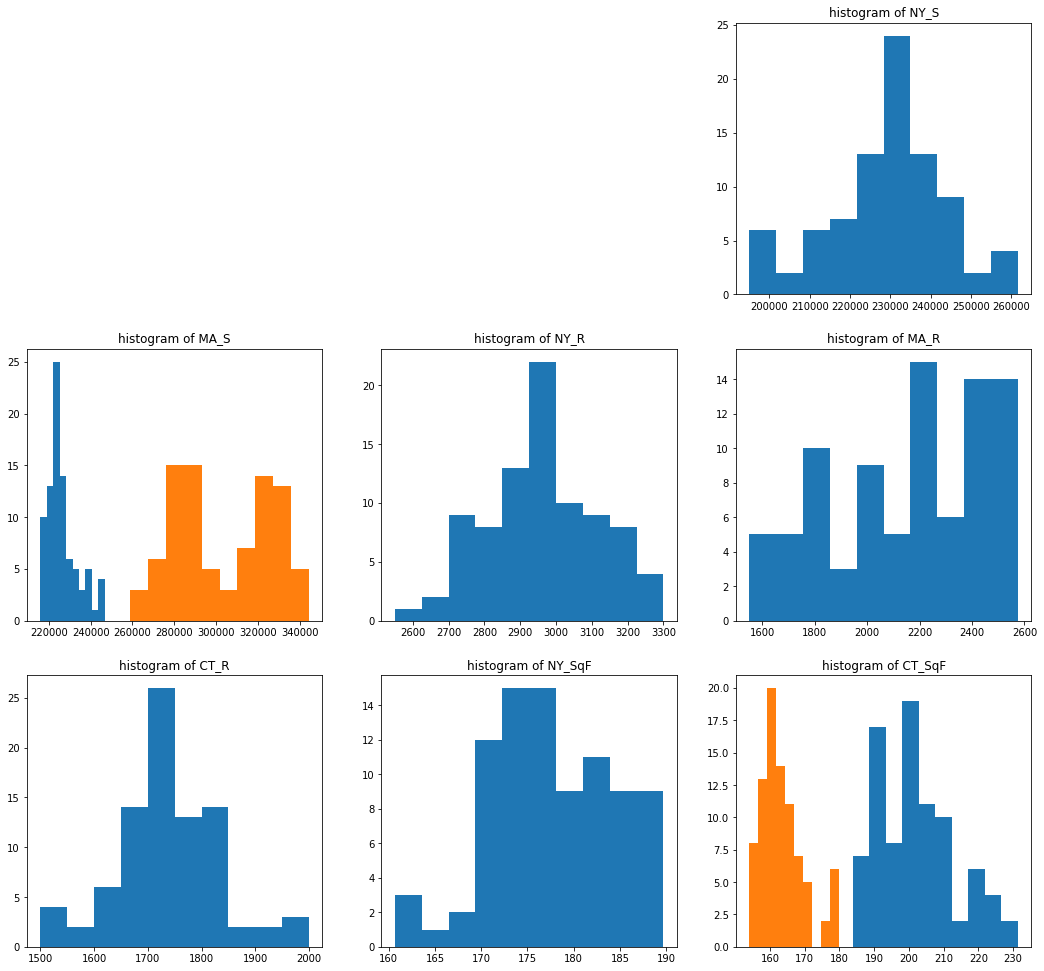

In [48]:
plt.figure(figsize=(18,17))

# histograms of the original data

plt.subplot(3, 3, 3)
plt.hist(df_product["NY_S"])
plt.title("histogram of NY_S")

plt.subplot(3, 3, 4)
plt.hist(df_product["CT_S"])
plt.title("histogram of CT_S")

plt.subplot(3, 3, 4)
plt.hist(df_product["MA_S"])
plt.title("histogram of MA_S")

plt.subplot(3, 3, 5)
plt.hist(df_product["NY_R"])
plt.title("histogram of NY_R")

plt.subplot(3, 3, 6)
plt.hist(df_product["MA_R"])
plt.title("histogram of MA_R")

plt.subplot(3, 3, 7)
plt.hist(df_product["CT_R"])
plt.title("histogram of CT_R")

plt.subplot(3, 3, 8)
plt.hist(df_product["NY_SqF"])
plt.title("histogram of NY_SqF")

plt.subplot(3, 3, 9)
plt.hist(df_product["MA_SqF"])
plt.title("histogram of MA_SqF")

plt.subplot(3, 3, 9)
plt.hist(df_product["CT_SqF"])
plt.title("histogram of CT_SqF")

plt.show()

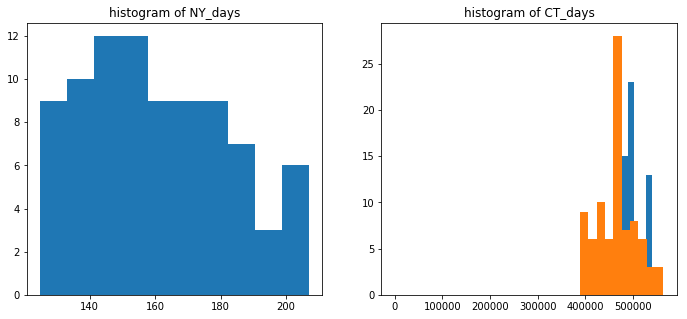

In [49]:
plt.figure(figsize=(18,17))

plt.subplot(3, 3, 9)
plt.hist(df_product["NYC_S"])
plt.title("histogram of NYC_S")

plt.subplot(3, 3, 9)
plt.hist(df_product["Boston_S"])
plt.title("histogram of Boston_S")

plt.subplot(3, 3, 8)
plt.hist(df_product["NY_days"])
plt.title("histogram of NY_days")

plt.subplot(3, 3, 9)
plt.hist(df_product["MA_days"])
plt.title("histogram of MA_days")

plt.subplot(3, 3, 9)
plt.hist(df_product["CT_days"])
plt.title("histogram of CT_days")

plt.show()

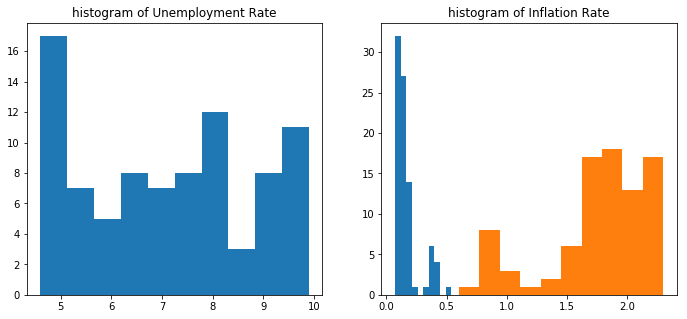

In [50]:
plt.figure(figsize=(18,17))

plt.subplot(3, 3, 1)
plt.hist(df_product["Unemployment Rate"])
plt.title("histogram of Unemployment Rate")

plt.subplot(3, 3, 2)
plt.hist(df_product["Effective Federal Funds Rate"])
plt.title("histogram of Effective Federal Funds Rate")

plt.subplot(3, 3, 2)
plt.hist(df_product["Inflation Rate"])
plt.title("histogram of Inflation Rate")

plt.show()

In [51]:
df_product.corr()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,CT_S,NY_R,MA_R,CT_R,NY_SqF,MA_SqF,CT_SqF,NY_days,MA_days,CT_days,NYC_S,Boston_S
Unemployment Rate,1.000000,-0.567792,-0.412873,-0.203463,-0.846257,0.646883,-0.404699,-0.897568,0.161916,0.107411,-0.664613,0.490576,0.356350,0.670839,0.269275,-0.654637,-0.404533
Inflation Rate,-0.567792,1.000000,0.226761,-0.292081,0.302287,-0.686274,-0.112227,0.560183,-0.338123,-0.410084,0.184165,-0.599160,0.008895,-0.276660,0.008403,0.172212,0.129743
Effective Federal Funds Rate,-0.412873,0.226761,1.000000,0.337151,0.427903,-0.107542,0.292015,0.298061,-0.030522,0.135650,0.607463,0.227949,-0.174988,-0.224157,-0.046054,0.663576,0.584745
NY_S,-0.203463,-0.292081,0.337151,1.000000,0.436525,0.298741,0.686133,0.233714,0.448681,0.269660,0.558531,0.355026,-0.377344,-0.219179,-0.206709,0.495551,0.547424
MA_S,-0.846257,0.302287,0.427903,0.436525,1.000000,-0.454701,0.524432,0.851731,0.014359,0.055553,0.871588,-0.166097,-0.461006,-0.662719,-0.273122,0.811260,0.594543
CT_S,0.646883,-0.686274,-0.107542,0.298741,-0.454701,1.000000,-0.041377,-0.579409,0.349452,0.080971,-0.218237,0.624478,0.037105,0.358514,-0.019675,-0.318925,-0.087607
NY_R,-0.404699,-0.112227,0.292015,0.686133,0.524432,-0.041377,1.000000,0.424851,0.489519,0.424668,0.545545,0.208625,-0.230950,-0.254160,-0.159175,0.642100,0.556753
MA_R,-0.897568,0.560183,0.298061,0.233714,0.851731,-0.579409,0.424851,1.000000,-0.186814,-0.095682,0.701787,-0.440379,-0.281739,-0.617457,-0.232971,0.655528,0.370110
CT_R,0.161916,-0.338123,-0.030522,0.448681,0.014359,0.349452,0.489519,-0.186814,1.000000,0.329224,0.136223,0.568929,-0.306125,-0.002193,-0.241918,0.067195,0.360014
NY_SqF,0.107411,-0.410084,0.135650,0.269660,0.055553,0.080971,0.424668,-0.095682,0.329224,1.000000,0.149704,0.386122,0.228641,0.269367,0.277938,0.153864,0.275795


# 3. Supervised Modeling! 

## We have looked over out data, normalized it, accounted for ouliers and created a DF with exactly the variables we want to isolate. Let's put that to work for us by loading them into a regression model. This will be the supervised portion of this project where we will use regression to better help us with predicting NYC and Boston sale prices for us in the future. 

### Let's start with OLS to get a baseline regression going to predict NYC Sale prices since that's where I currently live, and then move on to Boston: 



In [62]:

import warnings
warnings.filterwarnings(action="ignore")



X = df_product[['Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate', 
                'NY_S', 'MA_S', 'CT_S', 'NY_R', 'MA_R', 'CT_R', 'NY_SqF', 'MA_SqF', 
                'CT_SqF', 'NY_days', 'MA_days', 'CT_days', 'Boston_S']] 
Y = df_product['NYC_S']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))
print('score: ' + str(lrm.score(X,Y)))

The number of observations in training set is 68
The number of observations in test set is 18
R-squared of the model in the training set is: 0.8845891131583159
-----Test set statistics-----
R-squared of the model in the test set is: 0.9094647026309388
Mean absolute error of the prediction is: 6002.580721213676
Mean squared error of the prediction is: 59460830.32991208
Root mean squared error of the prediction is: 7711.084899669571
Mean absolute percentage error of the prediction is: 1.2155152075792688
coefficients: [ 5.87966590e+03 -1.13599846e+04  1.17095335e+05 -3.16340820e-01
  2.38591197e-01 -7.21930621e-01  8.46186653e+01  9.21652318e+00
 -9.89174105e+00 -4.99527242e+02  1.19363836e+03 -5.68463210e+02
 -3.84396392e+02  3.20121003e+01  3.79059366e+02 -1.26976278e-01]
intercept: 372778.20098374394
score: 0.8914482020036397


### Now let's try a robust regressor for comparison:

In [67]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



X = df_product[['Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate', 
                'NY_S', 'MA_S', 'CT_S', 'NY_R', 'MA_R', 'CT_R', 'NY_SqF', 'MA_SqF', 
                'CT_SqF', 'NY_days', 'MA_days', 'CT_days', 'Boston_S']] 
Y = df_product['NYC_S']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
hr = HuberRegressor()

hr.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))
print('score: ' + str(hr.score(X,Y)))

The number of observations in training set is 68
The number of observations in test set is 18
R-squared of the model in the training set is: 0.6038184636479693
-----Test set statistics-----
R-squared of the model in the test set is: 0.679563670563702
Mean absolute error of the prediction is: 11755.947836711712
Mean squared error of the prediction is: 210452837.39977732
Root mean squared error of the prediction is: 14506.992706959541
Mean absolute percentage error of the prediction is: 2.4203737343341136
coefficients: [ 1.08869323e-04 -2.25535939e-05  3.49326120e-05 -1.53857480e-01
  8.36369672e-01  6.95029611e-01  6.74953601e-02  2.73223143e-03
 -1.47631504e-04  1.72750620e-03  2.63426156e-03  1.95959025e-03
 -7.98410444e-08 -3.13314479e-03 -2.59827011e-03  2.58423953e-01]
intercept: 6.643952737760994e-06
score: 0.6254672184204131


### Let's try for Boston now! 

In [65]:

import warnings
warnings.filterwarnings(action="ignore")



X = df_product[['Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate', 
                'NY_S', 'MA_S', 'CT_S', 'NY_R', 'MA_R', 'CT_R', 'NY_SqF', 'MA_SqF', 
                'CT_SqF', 'NY_days', 'MA_days', 'CT_days', 'NYC_S']] 
Y = df_product['Boston_S']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))
print('score: ' + str(lrm.score(X,Y)))

The number of observations in training set is 68
The number of observations in test set is 18
R-squared of the model in the training set is: 0.8130407604196327
-----Test set statistics-----
R-squared of the model in the test set is: 0.5149245044678759
Mean absolute error of the prediction is: 20381.755775982612
Mean squared error of the prediction is: 581946944.5617805
Root mean squared error of the prediction is: 24123.576529233396
Mean absolute percentage error of the prediction is: 4.4703413966953685
coefficients: [ 4.79426133e+03  1.78402674e+04  1.23446694e+05 -2.06640196e-01
  7.50204180e-01 -6.33104316e-01  9.99998686e+01 -6.74902767e+01
  8.23278988e+01 -8.37474607e+02  3.55196510e+03 -1.43907057e+03
 -4.43387379e+02  1.06355917e+03  1.79837253e+01 -5.37972931e-01]
intercept: -60236.2014397296
score: 0.7700811948230084


In [66]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



X = df_product[['Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate', 
                'NY_S', 'MA_S', 'CT_S', 'NY_R', 'MA_R', 'CT_R', 'NY_SqF', 'MA_SqF', 
                'CT_SqF', 'NY_days', 'MA_days', 'CT_days', 'NYC_S']] 
Y = df_product['Boston_S']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
hr = HuberRegressor()

hr.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))
print('score: ' + str(hr.score(X,Y)))

The number of observations in training set is 68
The number of observations in test set is 18
R-squared of the model in the training set is: 0.4346674187098765
-----Test set statistics-----
R-squared of the model in the test set is: -0.07825433698607975
Mean absolute error of the prediction is: 26765.75020162483
Mean squared error of the prediction is: 1293585890.5451186
Root mean squared error of the prediction is: 35966.455073375226
Mean absolute percentage error of the prediction is: 5.907854748416673
coefficients: [ 3.64784650e-05 -2.96658506e-05  3.97342976e-05  1.49655608e+00
 -2.92584626e-01 -1.14273031e+00  6.35164598e-03 -5.44815099e-02
  1.21092690e-02 -3.63062097e-04  8.56696525e-04  1.05064928e-03
 -3.82417759e-03  2.40308763e-03 -5.55652944e-04  9.32072323e-01]
intercept: -4.875575518906383e-06
score: 0.36219428923554253


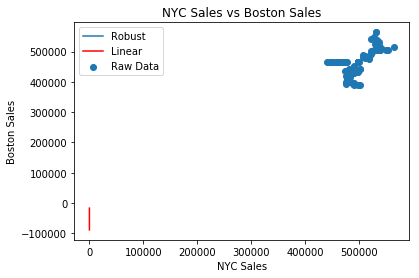

In [71]:
robust = [hr.coef_[0] * i + hr.intercept_ for i in range(-6, 10)]
linear = [lrm.coef_[0] * i + lrm.intercept_ for i in range(-6, 10)]

plt.scatter(x = df_product.NYC_S, y = df_product.Boston_S, label='Raw Data')
plt.plot(range(-6,10), robust, label='Robust')
plt.plot(range(-6,10), linear, 'r', label='Linear')
plt.legend()
plt.title('NYC Sales vs Boston Sales')
plt.xlabel('NYC Sales')
plt.ylabel('Boston Sales')
plt.show()

In [ ]:
#Probit and Tobit
#RANSAC, Thiel-Sen 

# Unsupervised Modeling! 

## Now we will use unsupervised models to try and help us find clusters of areas that would be optimal for examinging in the potential years to come. 

### Let's create a new X which has all our vaiables:


In [73]:


X2 = df_product[['Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate', 
                'NY_S', 'MA_S', 'CT_S', 'NY_R', 'MA_R', 'CT_R', 'NY_SqF', 'MA_SqF', 
                'CT_SqF', 'NY_days', 'MA_days', 'CT_days', 'Boston_S', 'NYC_S']] 



## Now we are ready to start looking at a few different clustering algorithms! 

### We will start with K means and then move on to Mean Shift, HDB Scan, DB Scan, Gaussian Mixture Model GMM and finish off with Fuzzy C Means so that we have a nice mix of heirarchical and fuzzy algorithms to see how they compare. We will also be seeing a silhouette score for each model so that we have some quantitative measure for each of these models. 

### K Means: How many clusters should we select? Let's use Elbow Visualizer to help us with that. 

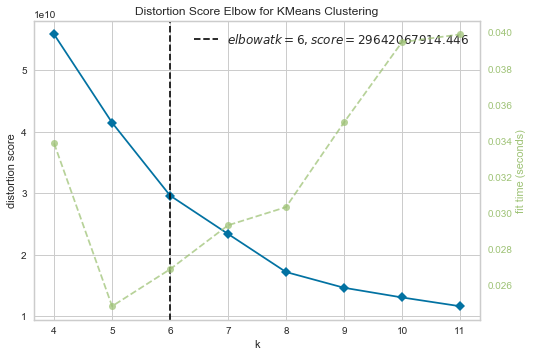

In [75]:


from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X2)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Let's also scale our data:

In [77]:

# Perform the necessary imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Create scaler: scaler
scaler = StandardScaler(X2)


In [78]:
# Import KMeans
from sklearn.cluster import KMeans

model = KMeans(n_clusters=6)

# Fit model to points
model.fit(X2)

# Determine the cluster labels of new_points: labels
labels = model.predict(X2)

# Print cluster labels of new_points
print(labels)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4
 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 5 1 5 5 5 5 5 5 5 5 5 5]


In [79]:
df_product['Label'] = labels 
print (df_product['Label'])

2010-01    3
2010-02    3
2010-03    3
2010-04    3
2010-05    3
          ..
2016-11    5
2016-12    5
2016-12    5
2017-03    5
2017-03    5
Name: Label, Length: 86, dtype: int32


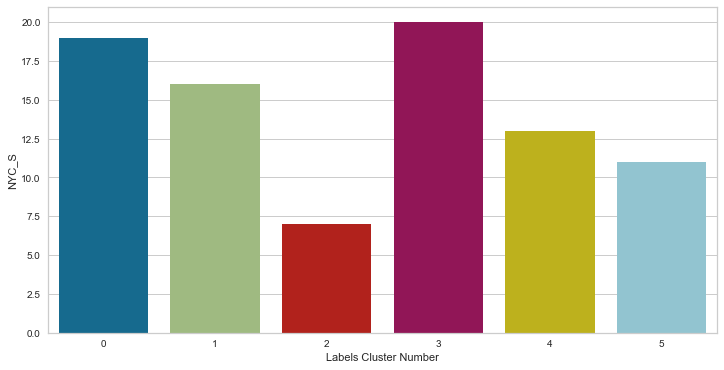

In [82]:


plt.figure(figsize=(12,6))
axis = sns.barplot(x= np.arange(0,6,1),y=df_product.groupby(['Label']).count()['NYC_S'].values)
x=axis.set_xlabel("Labels Cluster Number")
x=axis.set_ylabel("NYC_S")

In [83]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg = silhouette_score(X2, labels)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.4868975052625139


### Let's try Mean shift:

In [84]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X2, quantile=0.2, n_samples=40000)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X2)

# Extract cluster assignments for each data point.
meanshift_labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(meanshift_labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 3


In [85]:
df_product['meanshift_labels'] = meanshift_labels 
print (df_product['meanshift_labels'])

2010-01    0
2010-02    0
2010-03    0
2010-04    0
2010-05    0
          ..
2016-11    1
2016-12    1
2016-12    1
2017-03    1
2017-03    1
Name: meanshift_labels, Length: 86, dtype: int64


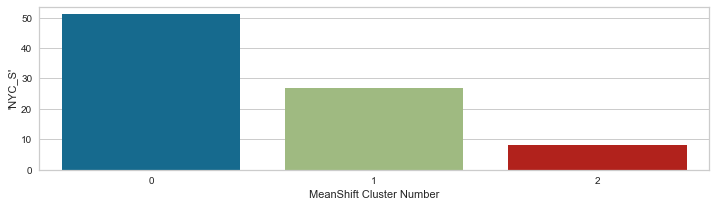

In [89]:
plt.figure(figsize=(12,3))
axis = sns.barplot(x= np.arange(0, 3, 1),y=df_product.groupby(['meanshift_labels']).count()['NYC_S'].values)
x=axis.set_xlabel("MeanShift Cluster Number")
x=axis.set_ylabel("'NYC_S'")

In [90]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg = silhouette_score(X2, meanshift_labels)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.4132762993730354


### HDB Scan:

In [91]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
hdbscan_labels = clusterer.fit_predict(X2)


# Print cluster labels of new_points
print(hdbscan_labels)

[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1  0  0  0 -1 -1 -1 -1
 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1 -1 -1 -1  1  1  1  1 -1 -1]


In [92]:
n_clusters_ = len(np.unique(hdbscan_labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 3


In [93]:
df_product['hdbscan_labels'] = hdbscan_labels 
print (df_product['hdbscan_labels'])

2010-01    0
2010-02    0
2010-03    0
2010-04    0
2010-05    0
          ..
2016-11    1
2016-12    1
2016-12    1
2017-03   -1
2017-03   -1
Name: hdbscan_labels, Length: 86, dtype: int64


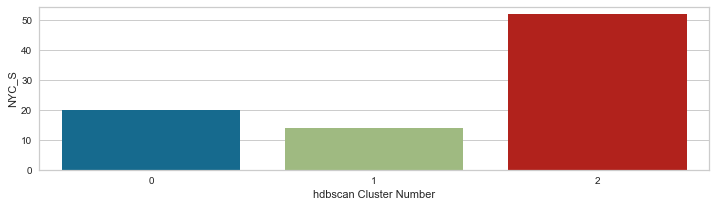

In [95]:
plt.figure(figsize=(12,3))
axis = sns.barplot(x= np.arange(0, 3, 1),y=df_product.groupby(['hdbscan_labels']).count()['NYC_S'].values)
x=axis.set_xlabel("hdbscan Cluster Number")
x=axis.set_ylabel("NYC_S")

In [96]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg = silhouette_score(X2, hdbscan_labels)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.0242355902497299


### GMM

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X2)
GMM_labels = gmm.predict(X2)
print(GMM_labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 3 0 3 3 3 3 3 3 3 3 3 3]


In [99]:
df_product['GMM_labels'] = GMM_labels

print (df_product['GMM_labels'])

2010-01    2
2010-02    2
2010-03    2
2010-04    2
2010-05    2
          ..
2016-11    3
2016-12    3
2016-12    3
2017-03    3
2017-03    3
Name: GMM_labels, Length: 86, dtype: int64


In [100]:
n_clusters_ = len(np.unique(GMM_labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 4


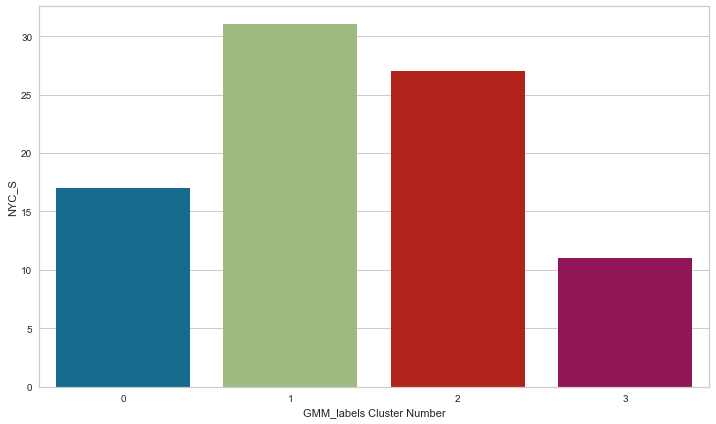

In [102]:
plt.figure(figsize=(12,7))
axis = sns.barplot(x= np.arange(0, 4, 1),y=df_product.groupby(['GMM_labels']).count()['NYC_S'].values)
x=axis.set_xlabel("GMM_labels Cluster Number")
x=axis.set_ylabel("NYC_S")

In [103]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg = silhouette_score(X2, GMM_labels)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.4109780937412955


### Fuzzy C Means: 

In [104]:
from fcmeans import FCM

fcm = FCM(n_clusters=7)
fcm.fit(X2)
fcm_labels = fcm.predict(X2)
fcm_probabilities = fcm.u

print(fcm_labels)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4
 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 1 1 1 1 1 1 1
 1 1 6 6 6 6 1 1 1 1 6 6]


In [105]:
df_product['fcm_labels'] = fcm_labels

print (df_product['fcm_labels'])


2010-01    3
2010-02    3
2010-03    3
2010-04    3
2010-05    3
          ..
2016-11    1
2016-12    1
2016-12    1
2017-03    6
2017-03    6
Name: fcm_labels, Length: 86, dtype: int64


In [106]:
n_clusters_ = len(np.unique(fcm_labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 7


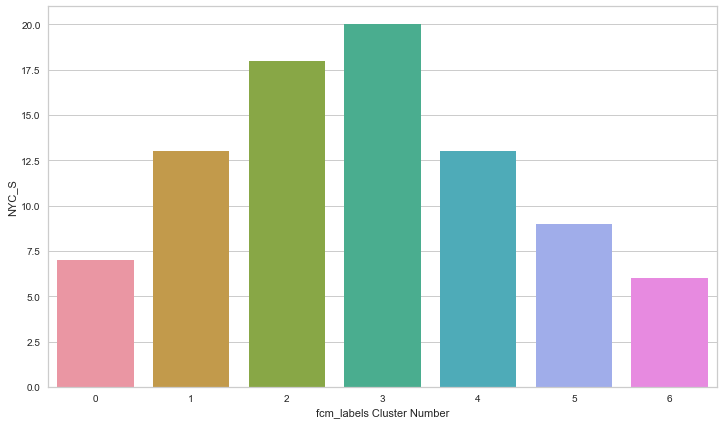

In [108]:
plt.figure(figsize=(12,7))
axis = sns.barplot(x= np.arange(0, 7, 1),y=df_product.groupby(['fcm_labels']).count()['NYC_S'].values)
x=axis.set_xlabel("fcm_labels Cluster Number")
x=axis.set_ylabel("NYC_S")

In [109]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg = silhouette_score(X2, fcm_labels)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.5008658643825652
